In [151]:
import os
import cv2
# import numpy as np
import yaml
import matplotlib.pyplot as plt

In [152]:
class NanoParticleSegmentation:
    def __init__(self, config_path="./config.yaml"):
        config = self.get_config(config_filepath=config_path)
        self.images_dir = config.get("images_dir", None)
        self.masks_dir = config.get("masks_dir", None)

        self.save_dir = config.get("save_dir", None)
        os.makedirs(self.save_dir, exist_ok=True)

    def get_config(self, config_filepath: str) -> dict:
        try:
            with open(config_filepath) as f:
                config = yaml.safe_load(f)
            return config
        except FileNotFoundError:
            return {}
        
    def get_gray_img(self, img_path):
        self.image = cv2.imread(img_path)
        gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        
        # Get the center of the image
        self.image_center = (self.image.shape[1] // 2, self.image.shape[0] // 2)

        return gray
        
    def contour_distance_to_center(self, contour):
        """
        Function to calculate the distance from the contour's centroid to the image center
        """
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            distance = np.sqrt((cX - self.image_center[0]) ** 2 + (cY - self.image_center[1]) ** 2)
            return distance
            
        return float('inf')

    def display_img(self, input_img, mask_img, seg_img, true_mask, img_save_path):
        # Display the results
        plt.figure(figsize=(10, 10))
        
        plt.subplot(2, 2, 1)
        plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(2, 2, 2)
        plt.title("True Mask")
        plt.imshow(true_mask, cmap="gray")
        plt.axis("off")

        plt.subplot(2, 2, 3)
        plt.title("Segmenation")
        plt.imshow(cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        
        plt.subplot(2, 2, 4)
        plt.title("Pred Mask")
        plt.imshow(mask_img, cmap="gray")
        plt.axis("off")
        
        
        plt.tight_layout()

        plt.savefig(img_save_path, dpi=300, bbox_inches="tight")
        # plt.show()
        plt.close()

    def sort_contours(self, contours):
        # Sort contours first by distance to center, then by area
        contours_sorted = sorted(contours, key=lambda contour: (self.contour_distance_to_center(contour), -cv2.contourArea(contour)))
        
        # Select the largest contour closest to the center
        largest_cent_contour = contours_sorted[0] if contours_sorted else None

        return largest_cent_contour

    def segment(self, gray_img):        
        # Apply Gaussian Blur to reduce noise
        blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)
        
        # Thresholding using the mean value
        _, thresh = cv2.threshold(blurred, np.mean(blurred), 255, cv2.THRESH_BINARY_INV)
        
        # Apply Morphological Opening to remove small patches
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        
        # Find contours in the processed image
        contours, hierarchy = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        largest_cent_contour = self.sort_contours(contours)
        
        # Create a blank mask and draw the largest contour
        mask = np.zeros_like(gray_img, dtype="uint8")
        if largest_cent_contour is not None:
            cv2.drawContours(mask, [largest_cent_contour], -1, (255), thickness=cv2.FILLED)
        
        # Fill small spaces in the mask
        filled_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

        color = (0, 0, 255)
        thickness = 1
        
        # Draw contours of the refined segmentation mask on the original image in red
        seg_img = self.image.copy()
        refined_contours, _ = cv2.findContours(filled_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(seg_img, refined_contours, -1, color, thickness)
        
        # Draw red lines at the edges of seg_img
        height, width, _ = seg_img.shape
         
        # Top edge
        cv2.line(seg_img, (0, 0), (width, 0), color, thickness)
        # Bottom edge
        cv2.line(seg_img, (0, height - 1), (width, height - 1), color, thickness)
        # Left edge
        cv2.line(seg_img, (0, 0), (0, height), color, thickness)
        # Right edge
        cv2.line(seg_img, (width - 1, 0), (width - 1, height), color, thickness)
    
        return gray_img, filled_mask, seg_img

    def process_all(self):
        for file_name in os.listdir(self.images_dir):
            if file_name.endswith((".png", ".jpg", ".jpeg")):
                img_path = os.path.join(self.images_dir, file_name)
                mask_path = os.path.join(self.masks_dir, f"{file_name.split('.')[0]}_mask.png")
                
                gray_img = self.get_gray_img(img_path)
                true_mask = cv2.imread(mask_path)
                
                gray_img, filled_mask, seg_img = self.segment(gray_img)
                img_save_path = os.path.join(self.save_dir, file_name)
                self.display_img(gray_img, filled_mask, seg_img, true_mask, img_save_path)
                break


In [153]:
nano_particle_segmentor = NanoParticleSegmentation()

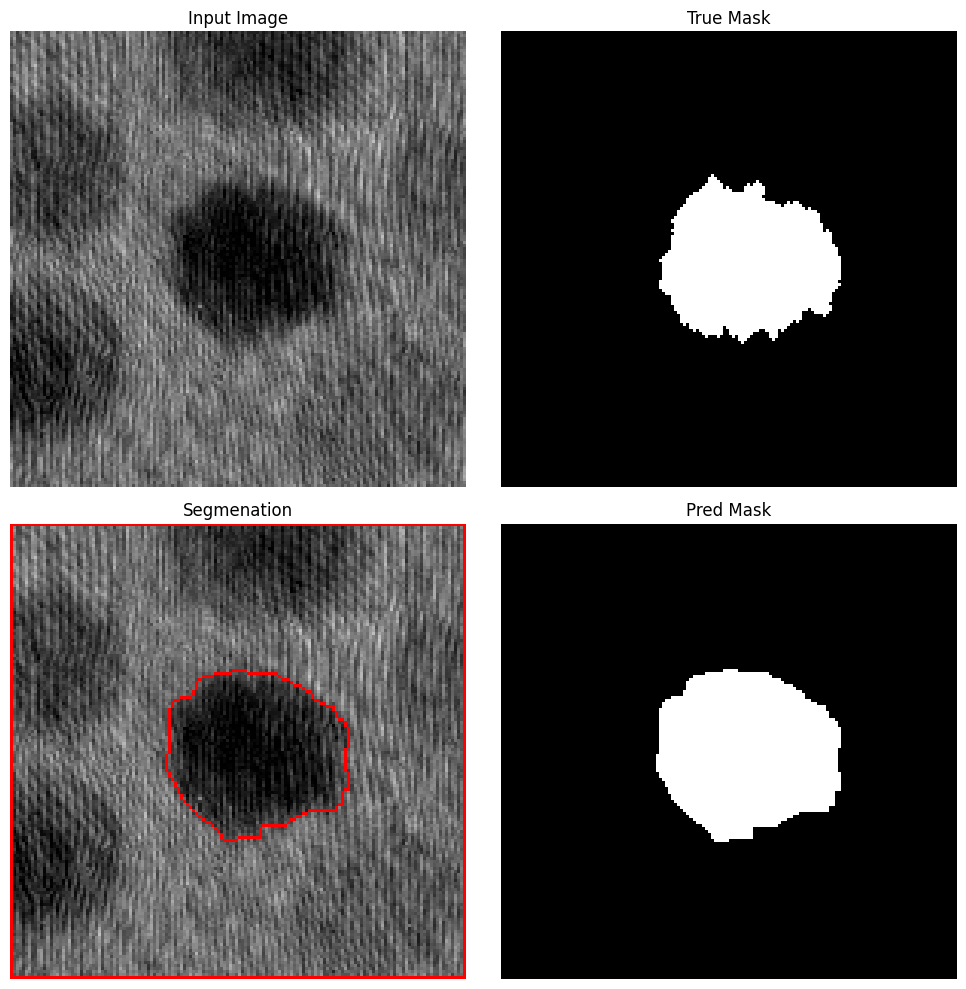

In [154]:
nano_particle_segmentor.process_all()

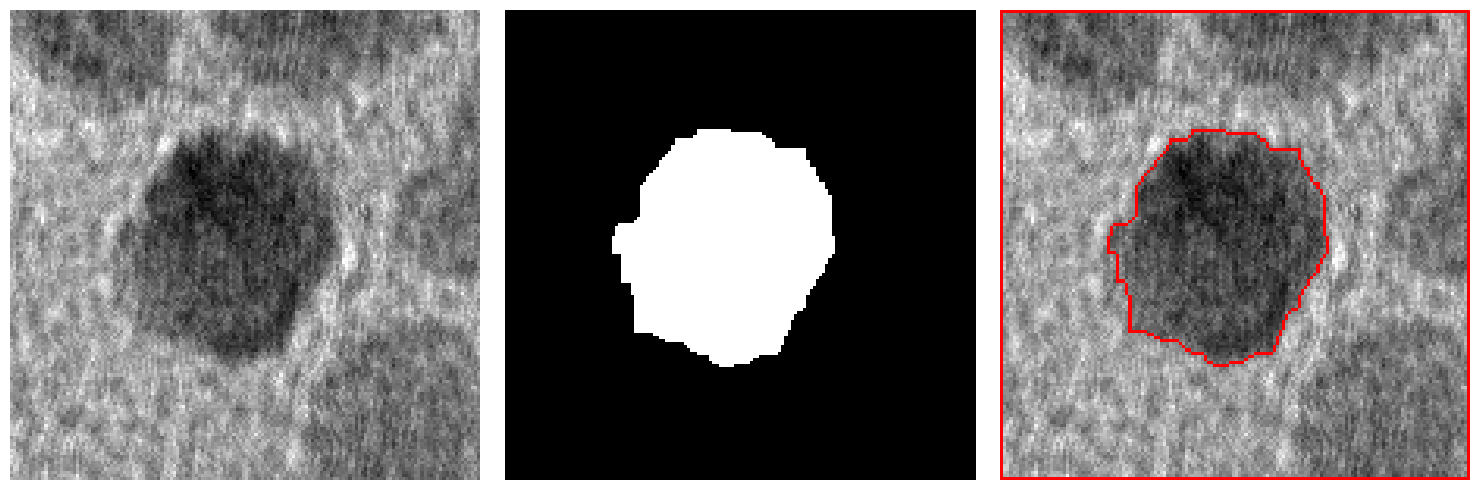

In [112]:
img_path = r"C:\Users\penda\Documents\Study Materials\Image Processing\PROJECT\PROJECT DATASET\Images\TEM67\TEM67_crop2.jpg"
nano_particle_segmentor.process_single(img_path)